### Least-Squares Approximation

Numerically, it is relatively simple to state the approximation problem for the least-square norm.  This is the topic of this section.

#### Linear Least-squares approximation

In the context of linear least-squares approximation, it is always possible to reduce the problem to solving a system of linear equations, as the following example shows:

Consider the sine function $f(x) = \sin(x)$ in the interval from 0 to 1.  We choose as approximants the polynomials of second degree: $\{a_0 + a_1 x + a_2 x^2 \}$.  To compute the values $[a_0, a_1, a_2]$ that minimize this problem, we form first a 3-by-3 matrix containing the pairwise _dot products_ (the integral of the product of two functions) of the basic functions $\{1, x, x^2\}$ in the given interval.  Due to the nature of this problem, we obtain a Hilbert matrix of order 3:

$$\begin{pmatrix}
\langle 1,1 \rangle & \langle 1, x \rangle & \langle 1, x^2 \rangle \\
\langle x,1 \rangle & \langle x, x \rangle & \langle x, x^2 \rangle \\
\langle x^2,1 \rangle & \langle x^2, x \rangle & \langle x^2, x^2 \rangle
\end{pmatrix} = \begin{pmatrix}
1 & 1/2 & 1/3 \\
1/2 & 1/3 & 1/4 \\
1/3 & 1/4 & 1/5
\end{pmatrix}
$$

The right-hand side of the system is the column vector with the dot product of the sine function with each basic function in the given interval:

$$\begin{pmatrix}
\langle \sin x, 1 \rangle \\
\langle \sin x, x \rangle \\
\langle \sin x, x^2 \rangle
\end{pmatrix} = \begin{pmatrix}
1 - \cos(1) \\
\sin(1) - \cos(1) \\
2\sin(1) + \cos(1) - 2
\end{pmatrix}
$$

We compute the coefficients and the corresponding approximation polynomial as follows:

In [1]:
import numpy as np, scipy.linalg as spla, matplotlib.pyplot as plt
    
%matplotlib inline

A = spla.hilbert(3)
b = np.array([1-np.cos(1), np.sin(1)-np.cos(1), 2*np.sin(1)+np.cos(1)-2])
   
print spla.solve(A, b)

poly1 = np.poly1d(spla.solve(A, b)[::-1])
print poly1

[-0.00746493  1.09129978 -0.2354618 ]
         2
-0.2355 x + 1.091 x - 0.007465


In general, to resolve a linear least-square approximation problem for a basis with `r` elements, we need to solve a basic system of linear equations with `r` equations and `r` indeterminates.  In spite of its apparent simplicity, this method is far from perfect.

* The system may be *ill-conditioned*, as it was the case of the previous example.
* *Non-permanence of the coefficients*: The value of the coefficients depend very heavily on `r`.  Increasing the dimension of the problem results in a new set of coefficients, different from the previous.

> There are ways to remediate the ill-conditioning of the system. One standard procedure is to construct an orthogonal basis from the original, with Gram-Schmidth and modified Gram-Schmidt orthogonalization methods. This topic is beyond the scope of this monograph, but a  good reference for these methods can be read in chapter 1 of the book _Numerical Analysis_, by Walter Gautschi. Birkhäuser 1997.

A basis that always provides simple linear systems is the B-splines.  All the systems involved are *tridiagonal*, and thus easily solvable without the need of complex operations.  The object-oriented system coded in the module `scipy.interpolate` allows us to perform all these computations internally.   This is a brief enumeration of the classes and subclasses involved:

* `UnivariateSpline` for splines in one dimension, or splines of curves in any dimension.  We seldom use this class directly, and resort instead to the subclass `LSQUnivariateSpline`.
* `BivariateSpline` for splines representing surfaces over nodes placed on a rectangle.  As its univariate counterpart, this class must not be used directly.  Instead, we utilize the subclass `LSQBivariateSpline`.
* `SphereBivariateSpline` for splines representing surfaces over nodes placed on a sphere.  The computations must be carried through the subclass `LSQSphereBivariateSpline` instead.

> In all three cases, the base classes and their methods are their counterparts in the problem of interpolation.  Refer to the previous section for technical information, if needed.

Let us illustrate these object-oriented techniques with a few selected examples:

Approximate the same sine function on the same domain, with cubic splines (`k=3`), in the sense of least-squares.  Note first that we must provide with a bounding box, a set of knots on the domain, as well as the weights `w` for the least-square approximation.  We are also allowed to provide with an optional smoothness parameter `s`.  If `s=0` we obtain interpolation instead, and for large values of `s` we achieve different degrees of smoothness of the resulting spline.  To obtain a reliable (weighted) least-squares approximation, a good choice is `s=len(w)` (which is what the routine does by default). Note also how small is the computed error:

In [2]:
f = np.sin
x = np.linspace(0,1,100)
knots = np.linspace(0,1,7)[1:-1]
weights = np.ones_like(x)

from scipy.interpolate import LSQUnivariateSpline

approximant = LSQUnivariateSpline(x, f(x), knots, k=3, w = weights, bbox = [0, 1]) 

spla.norm(f(x) - approximant(x))

3.3701750092625504e-06

> A more convenient way to compute this error of approximation is by using the method `.get_residual`, which gives us precisely the square of the previous norm.


In [3]:
approximant.get_residual()**(.5)

3.37017500928446e-06

Approximate the two-dimensional function $\sin(x)+\sin(y)$ on the domain $[-3,3] \times [-3,3]$.  We choose first a representation of the domain, a set of 100 suitable knots on a grid, and the set of weights.   Since all inputs to the function `LSQBivariateSpline` must be one-dimensional arrays, we perform the corresponding conversions prior to calling the approximation function:

In [4]:
def f(x, y): return np.sin(x) + np.sin(y)
t = np.linspace(-3, 3, 100)
domain = np.meshgrid(t, t)
X, Y = domain
Z = f(*domain)

X = X.ravel()
Y = Y.ravel()
Z = Z.ravel()

kx = np.linspace(-3,3,12)[1:-1]
ky = kx.copy()
weights = np.ones_like(Z);
   
from scipy.interpolate import LSQBivariateSpline

One advantage of this method is that, if the system is ill-conditioned, we get a warning explaining so:


In [5]:
approximant = LSQBivariateSpline(X, Y, Z, kx, kx, w = weights)

In [6]:
approximant.get_residual()

8.483425130594773e-05

> It is also possible to perform this computation with the function `RectBivariateSpline`.  To achieve least-squares interpolation, we provide nodes (instead of knots, since these will be computed automatically), weights `w`, and a smoothness parameter `s` large enough.  A good choice is usually `s = len(w)`.

#### Non-linear least-squares approximation

In the context of nonlinear least square approximations, we do not usually have the luxury of simple matrix representations.  Instead, we make use of two variations of an iterative process, the *Levenberg-Marquardt algorithm*, which are hosted in the module `scipy.optimize`.  The two versions, which correspond to the routines `LMDER` and `LMDIF` from the `Fortran` library `MINPACK`, can be called through the wrapper `leastsq`. 

|        |                           |
|--------|---------------------------|
| `func` | The error function `F(a)` |
| `x0` | The starting estimate for the minimization, of size `r` |
| `args` | extra arguments to `func`, as a tuple |
| `Dfun` | A function representing the Jacobian matrix of `func` |
| `full_output` | Boolean |
| `col_deriv` | Boolean. |
| `ftol` | The relative error desired in sums of squares |
| `xtol` | Relative error desired in the approximate solution |
| `gtol` | Orthogonality desired between `func` and the columns of `Dfun` |
| `maxfev` | maximum number of calls.  If zero, the number of calls is `100*(r+1)` |
| `epsfcn` | If `Dfun=None`, we may specify a floating-point value as the step in the forward-difference approximation of the Jacobian |
| `factor` | A floating-point value between 0.1 and 100, indicating the initial step bound |
| `diag` | Scale factors for each of the variables |

The first variant of the algorithm is used when we have a trusted Jacobian for the error function.  If this is not provided, a second variant of the algorithm is used, that approximates the Jacobian by forward differences.  We illustrate both variants with several examples.

Let us start revisiting a previous example with this method, to see the differences in usage and accuracy.  We will focus the computations on a partition of the interval from 0 to 1, with 100 uniformly spaced points.

In [7]:
from scipy.optimize import leastsq

def error_function(a):
    return a[0] + a[1] * x + a[2] * x**2 - np.sin(x)

def jacobian(a):
    return np.array([np.ones(100), x, x**2])

coeffs, success = leastsq(error_function, np.zeros((3,)))

poly2 = np.poly1d(coeffs[::-1])
print poly2

coeffs, success = leastsq(error_function, np.zeros((3,)), Dfun = jacobian, col_deriv=True)
   
poly3 = np.poly1d(coeffs[::-1])
print poly3

map(lambda f: spla.norm(np.sin(x) - f(x)), [poly1, poly2, poly3])

         2
-0.2354 x + 1.091 x - 0.007232
         2
-0.2354 x + 1.091 x - 0.007232


[0.028112146265269786, 0.028083775413880314, 0.02808377541388009]

> There is another function in the module `scipy.optimize` to perform non-linear least squares approximation: `curve_fit`.  It uses the same algorithm, but instead of an error function, we feed it a generic approximant `g[a](x)`, together with a suitable domain for the independent variable `x`, and the output of the target function `f` on the same domain.  We do need to input an initial estimate as well.  The output is, together with the required coefficients, an estimation of the covariance of said coefficients.  

In [8]:
from scipy.optimize import curve_fit

def approximant(t, a, b, c):
    return a + b * t + c * t**2

curve_fit(approximant, x, np.sin(x), np.ones((3,)))

(array([-0.007232  ,  1.09078356, -0.23537796]),
 array([[  7.03274163e-07,  -2.79884256e-06,   2.32064835e-06],
        [ -2.79884256e-06,   1.50223585e-05,  -1.40659702e-05],
        [  2.32064835e-06,  -1.40659702e-05,   1.40659703e-05]]))

> In this section we focus on the function `leastsq` exclusively.  The goals and coding of both functions are the same, but `leastsq` offers a more informative output on demand, and more control over the different parameters of the Levenberg-Marquardt algorithm.

Let us experiment now with a few actual nonlinear problems:

In the first example, we are going to approximate the function $\tan(2x)$ in the interval from 0 to 1 with rational functions where each of the polynomials has at most degree 1.

In [9]:
def error_function(a):
    return (a[0] + a[1]*x) / (a[2] + a[3]*x) - np.tan(2*x)

def jacobian(a):
    numerator = a[0] + a[1]*x
    denominator = a[2] + a[3]*x
    return np.array( [ 1./denominator, x/denominator, 
                      -1.0*numerator/denominator**2,
                      -1.0*x*numerator/denominator**2 ])

To show the dependence of the initial estimation, we are going to experiment with three different choices:  one that makes no sense (all zero coefficients), one _blind_ standard choice (with all entries equal to one), and one choice that acknowledges the fact that the function $\tan(2x)$ has a vertical asymptote.  We will pretend we do not know the exact location, and approximate it to 0.78.  Our third initial estimation then represents a simple rational function with an asymptote at 0.78.

The _wrong_ initial estimate does not give us anything useful, obviously:

In [10]:
x1 = np.zeros((4,))
x2 = np.ones((4,))
x3 = np.array([1,0,0.78,-1])

coeffs, success = leastsq(error_function, x1)
numerator = np.poly1d(coeffs[1::-1])
denominator = np.poly1d(coeffs[:1:-1])
print numerator, denominator

coeffs, success = leastsq(error_function, x1, Dfun=jacobian, col_deriv=True)
numerator = np.poly1d(coeffs[1::-1])
denominator = np.poly1d(coeffs[:1:-1])
print numerator, denominator

 
0  
0
 
0  
0


/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: invalid value encountered in divide
  from IPython.kernel.zmq import kernelapp as app
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: divide by zero encountered in divide
  from IPython.kernel.zmq import kernelapp as app
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: RuntimeWarning: divide by zero encountered in divide
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: RuntimeWarning: invalid value encountered in divide


None of these two approximations using `x2` as initial guess are satisfactory: not only the corresponding errors are huge, but also neither solution has an asymptote in the interval from 0 to 1.

In [11]:
coeffs, success = leastsq(error_function, x2)
numerator = np.poly1d(coeffs[1::-1])
denominator = np.poly1d(coeffs[:1:-1])
print numerator, denominator
spla.norm(np.tan(2*x) - numerator(x) / denominator(x))

 
-9.729 x + 4.28  
-1.293 x + 1.986


220.59056436054013

In [12]:
coeffs, success = leastsq(error_function, x2, Dfun=jacobian, col_deriv=True)
numerator = np.poly1d(coeffs[1::-1])
denominator = np.poly1d(coeffs[:1:-1])
print numerator, denominator
spla.norm(np.tan(2*x) - numerator(x) / denominator(x))

 
-655.9 x + 288.5  
-87.05 x + 133.8


220.59056497850406

The approximations using `x3` as initial guess are closer to the target function, and they both have an acceptable asymptote.


In [13]:
coeffs, success = leastsq(error_function, x3)
numerator = np.poly1d(coeffs[1::-1])
denominator = np.poly1d(coeffs[:1:-1])
print numerator, denominator
spla.norm(np.tan(2*x) - numerator(x) / denominator(x))

 
0.01553 x + 0.02421  
-0.07285 x + 0.05721


2.185984698129936

In [14]:
coeffs, success = leastsq(error_function, x3, Dfun=jacobian, col_deriv=True)
numerator = np.poly1d(coeffs[1::-1])
denominator = np.poly1d(coeffs[:1:-1])
print numerator, denominator
spla.norm(np.tan(2*x) - numerator(x) / denominator(x))

 
17.17 x + 26.76  
-80.52 x + 63.24


2.1859846981334954

We can do much better, of course, but these simple examples will suffice for now.

If we desire to output more information to monitor the quality of approximation, we may do so with the option `full_output` set to `True`:

In [15]:
approximation_info = leastsq(error_function, x3, full_output=True)

coeffs = approximation_info[0]
print coeffs
    
message = approximation_info[-2]
print message
  
infodict = approximation_info[2]
print 'The algorithm performed {0:2d} iterations'.format(infodict['nfev'])

[ 0.02420694  0.01553346  0.0572128  -0.07284579]
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
The algorithm performed 97 iterations


Although technically the `leastsq` algorithm deals mostly with approximation to univariate functions, it is possible to work on multivariate functions with the aid of *indices*, *raveling*, *unpacking* (with the special * operator), and *stable sums*.  

> The usual sums of floating-point numbers of a `ndarray` with the `numpy` instance method `sum` (or with the `numpy` function `sum`) is far from stable.  We firmly recommend against using it for fairly large sums of numbers.  The following example shows an undesired scenario, in which we try to add 4000 values:


In [16]:
>>> arr = np.array( [1, 1e20, 1, -1e20] * 1000, dtype=np.float64)
>>> arr.sum()          # The answer should be, of course, 2000

0.0

> To resolve this situation, we make use of *stable sums*.  In the `math` module there is an implementation of the Shewchuk algorithm for this very purpose:

In [17]:
>>> from math import fsum
>>> fsum(arr)

2000.0

> For more information about the Shewchuk algorithm, as well as other common pitfalls to avoid in scientific computing with floating-point arithmetic, we recommend the excellent guide _What Every Computer Scientist Should Know About Floating Point Arithmetic_, by David Goldberg.  ACM Computing Surveys, 1991. vol.23, pp.5--48

This process is best explained with an example. We start by generating the target function: an image of size 32-by-32 containing white noise on top of the addition of three spherical Gaussian functions with different locations, variances and heights.  We collect all these values in a 3-by-4 array that we name `values`.  The first and second columns contain the x- and y-values of the coordinates of the centers.  The third column contains the heights, and the fourth column contains the variances.


In [22]:
def sphericalGaussian(x0, y0, h, v):
    return lambda x,y: h * np.exp(-0.5 * ((x-x0)**2+(y-y0)**2) / v)
   
domain = np.indices((32, 32))
values = np.random.randn(3,4)
values[:,:2] += np.random.randint(1, 32, size=(3, 2))
values[:,2] += np.random.randint(1, 64, size=3)
values[:,3] += np.random.randint(1, 16, size=3)
print values
   
img = np.random.randn(32,32)

for k in xrange(3):
    img += sphericalGaussian(*values[k])(*domain)

[[  7.94982824  21.00554124   3.15042631   1.63563371]
 [ 13.40441166  17.11746965  52.2666025    1.42431161]
 [ 13.8516027   30.25103081  60.8535315    6.63065195]]


Let us assume that we do not know the centers, heights, and variances, and wish to estimate them from the target image `img`.  We create then an error function to compute those 12 coefficients, which are packed in a 3-by-4 array `a`.  Note the role of the `numpy` function `ravel` and the instance method `reshape`, to ensure that data is handled correctly:

In [23]:
from math import fsum

def error_function(a):
    a = a.reshape(3,4)
    cx = a[:,0]    # x-coords
    cy = a[:,1]    # y-coords
    H = a[:,2]     # heights
    V = a[:,3]     # variances
    guess = np.zeros_like(img)
    for i in xrange(guess.shape[0]):
        for j in xrange(guess.shape[1]):
            guess[i,j] = fsum(H*np.exp(-0.5*((i-cx)**2+(j-cy)**2)/V))
    return np.ravel(guess-img)

Starting the process of least squares in this situation with guarantees of success requires a somewhat close initial guess.  For this particular example, we are going to produce our initial guess from the array `values`:

In [24]:
x0 = np.vectorize(int)(values)
print x0

leastsq(error_function, x0)

[[ 7 21  3  1]
 [13 17 52  1]
 [13 30 60  6]]


(array([  8.01189123,  20.93070982,   3.8738773 ,   1.00221117,
         13.42829831,  17.10654582,  51.66064283,   1.44346865,
         13.88957287,  30.24770182,  60.63371456,   6.64995729]), 1)

Let us visually compare both the target image `img` and its minimization by this procedure:

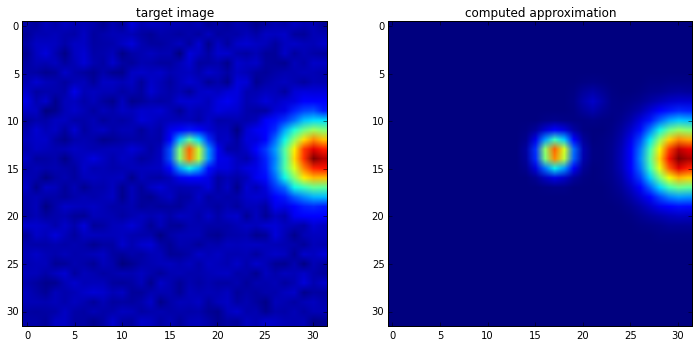

In [25]:
coeffs, success = _
coeffs = coeffs.reshape(3,4)

output = np.zeros_like(img)

for k in xrange(3):
    output += sphericalGaussian(*coeffs[k])(*domain)

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(img)
plt.title('target image')
plt.subplot(122)
plt.imshow(output)
plt.title('computed approximation')
plt.show()